## Exploratory Data Analysis del Caso base

In [294]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp
import numpy as np
from scipy.misc import derivative as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [297]:
γ = 1/2.4
fecha_inicio = pd.to_datetime("27-february-2020")
r = 0.7
inicio_red = 25
f = 0.9
q = 0.1356473594548552
ν = 5/12
η = 1/7
ϵ = 1/1.4
θ = 1/2.4
pa, pm, ps = 0.5, 0.476, 0.024
σ = 1/4.7
ξ = 1/4
τ = 1/5

## Defunciones

In [98]:
defun = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_miZMVM.csv",
           index_col = 0);
acumdefun = defun.cumsum(axis = 1).iloc[:, :75]

Elegimos 5 ciudades al azar para ver la forma en que se comportan las series de tiempo de defunciones:

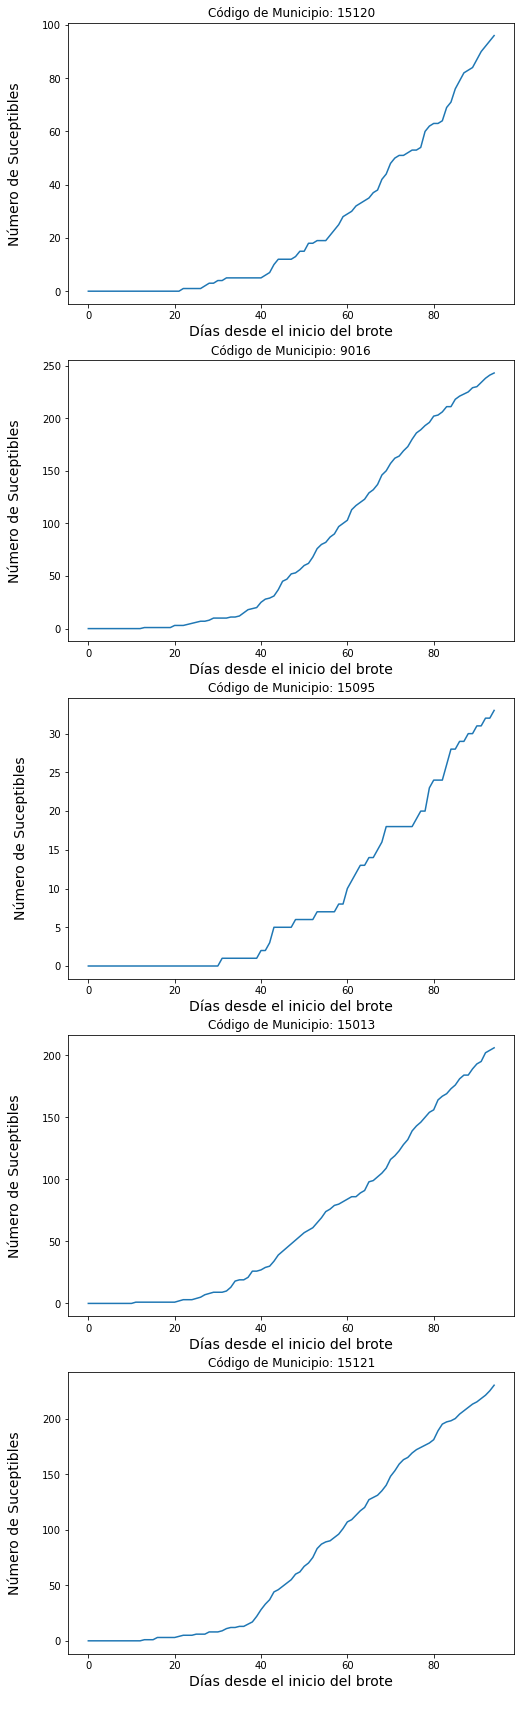

In [75]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))

for i in range(5):
    ax[i].plot(range(95), acumdefun.iloc[index[i]])
    ax[i].set_title('Código de Municipio: {}'.format(acumdefun.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde el inicio del brote\n', fontsize = 14)

Parece que se le puede ajustar una curva logísitca de la forma $f(x) = A + \frac{(K-A)}{C+Qe^{-B(t+t0) + J}}$. Habiendo inspeccionado todas las series del tiempo, hay algunas que no se ajustan bien (tienen muy pocos casos y hay un brinco tipo función escalera), suponemos que en estas ciudades no se registraron casos.

In [248]:
D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))

In [249]:
paramsD = []

for i in range(47):

    try:
        y = acumdefun.iloc[i, :75]
        fit = optimize.curve_fit(D, list(range(20, 95)), y, maxfev=1000)[0]
        paramsD.append(fit)
    except: # los que no se ajustan bien tienen ínidces 17, 28
        paramsD.append([0, 1, 0, 0, 0])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_24108\2150841193.py:1: RuntimeWarning: overflow encountered in exp
  D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Veamos cómo se ajusta nuestro modelo de defunciones:

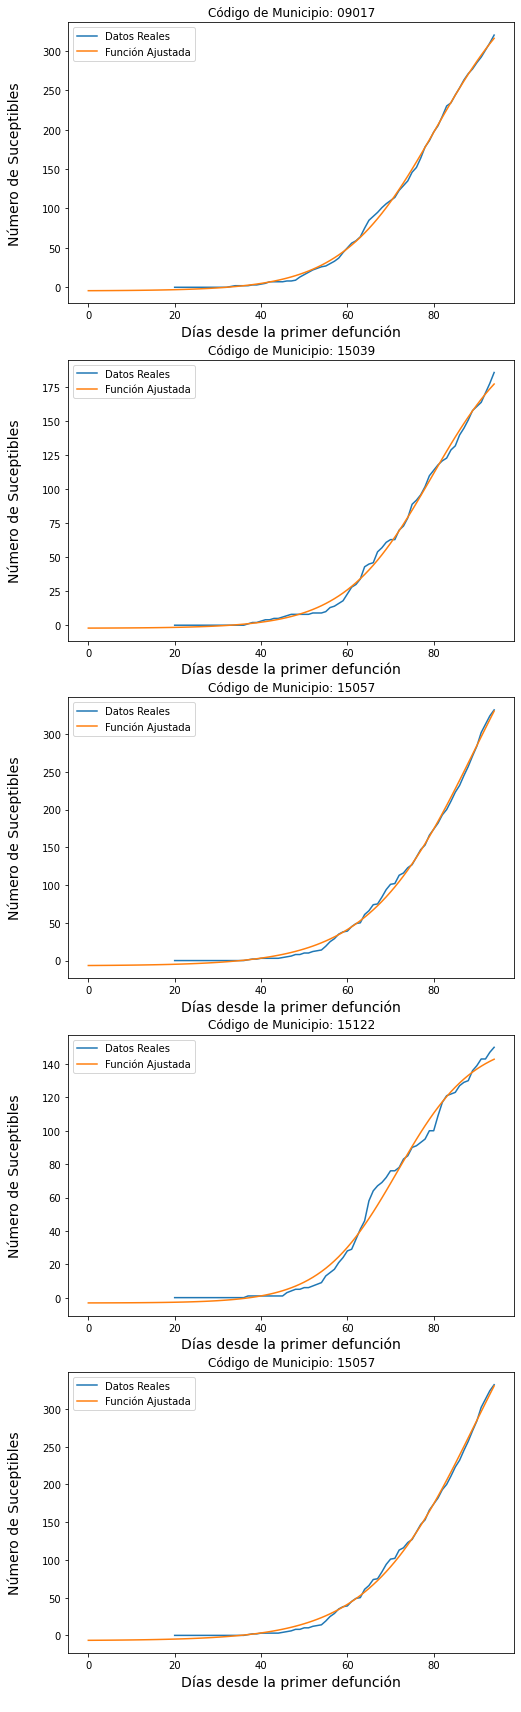

In [254]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))
t = np.array(range(95))

for i in range(5):
    ax[i].plot(range(20, 95), acumdefun.iloc[index[i]], label = 'Datos Reales')
    ax[i].plot(t, D(t, *paramsD[index[i]]), label = 'Función Ajustada')
    ax[i].set_title('Código de Municipio: {}'.format(S.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde la primer defunción\n', fontsize = 14)
    ax[i].legend()

plt.show()

De la ecuación diferencial tenemos que $\frac{dD_i}{dt} = q\xi H_i(t) \Rightarrow H_i(t) = \frac{1}{q\xi}\cdot \frac{dD_i}{dt} $

In [252]:
H = lambda t, i: 1/(q*ξ) * dt(D, t, n=1, args = (*paramsD[i], ))

Además, $\frac{dH_i}{dt} = \sigma I_{ss_i} - q\xi H_i - (1-q)\tau H_i \Rightarrow I_{ss_i}(t) = \frac{1}{\sigma}\left(\frac{dH_i}{dt} + \left(q\xi + (1-q)\tau\right)H_i \right)$

In [256]:
Iss = lambda t, i : (dt(H, t, n=1, args = (i,)) + (q*ξ + (1-q)*τ)*H(t, i))/σ

Luego, $\frac{dI_{ss_i}}{dt} = \theta p_s I_{p_i} - \sigma I_{ss_i}$, de donde $I_{p_i}(t) = \frac{1}{\theta p_s}\left(\frac{dI_{ss_i}}{dt} + \sigma I_{ss_i} \right)$

In [262]:
Ip = lambda t, i: 1/(θ*ps)*(dt(Iss, t, n=1, args = (i, )) + σ*Iss(t, i))

Para el resto de los infectados, podemos resolver sus ecuaciones diferenciales de manera numérica:

In [269]:
def IaEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(47)
    
    Ia = lambda i: X[i]
            
    for i in range(47):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pa*Ip(t, i) - γ*Ia(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Ia0 = np.zeros(47)
indicesCasos = [3, 5, 34]
Ia0[indicesCasos] = 1


solIa = solve_ivp(IaEDO, (0, 94), Ia0, t_eval = tdata)

In [276]:
Ia = lambda t, i: solIa.y[i, np.array(t).astype(int)]

In [271]:
def ImEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(47)
    
    Im = lambda i: X[i]
            
    for i in range(47):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pm*Ip(t, i) - γ*Im(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Im0 = np.zeros(47)


solIm = solve_ivp(ImEDO, (0, 94), Im0, t_eval = tdata)

In [274]:
Im = lambda t, i: solIm.y[i, np.array(t).astype(int)]

## Suceptibles

Dados los datos reales, queremos ver cómo se comporta su serie de tiempo:

In [33]:
casos = pd.read_csv('https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/positivos_miZMVM.csv',
        index_col = 0, dtype = {'cve_ent':str});
acumcasos = casos.cumsum(axis = 1).iloc[:, :95]

In [34]:
pob = pd.read_csv('https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_miZMVM.csv',
                 index_col = 0, dtype = {'cve_umun':str})

In [35]:
pob = pob['pop']

In [36]:
S = acumcasos.copy()

In [37]:
for i in S.index:
    for t in S.columns:
        S.loc[i, t] = pob[i] - S.loc[i, t]

Una vez con los datos de los suceptibles, elegimos 5 ciudades al azar y graficamos su serie de tiempo:

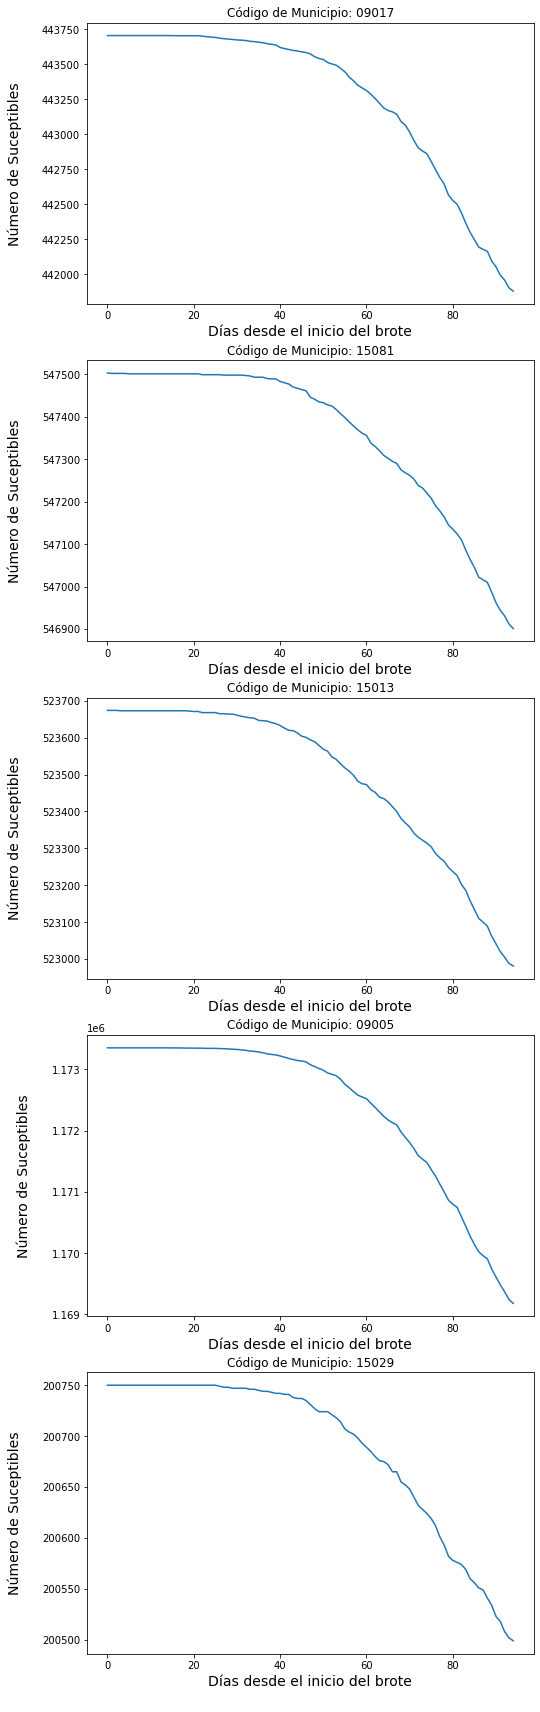

In [61]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))

for i in range(5):
    ax[i].plot(range(95), S.iloc[index[i]])
    ax[i].set_title('Código de Municipio: {}'.format(S.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde el inicio del brote\n', fontsize = 14)

A todos las series de tiempo les vamos a ajustar un polinomio de grado 4. Obtenemos los parámetros para cada conjunto:

In [286]:
paramsSuc = []
t = list(range(95))
Σ = lambda t, p0, p1, p2, p3, p4: p0 + p1*t + p2*t**2 + p3*t**3 + p4*t**4

for i in range(47):
    p = optimize.curve_fit(Σ, t, S.iloc[i])[0]
    paramsSuc.append(p)

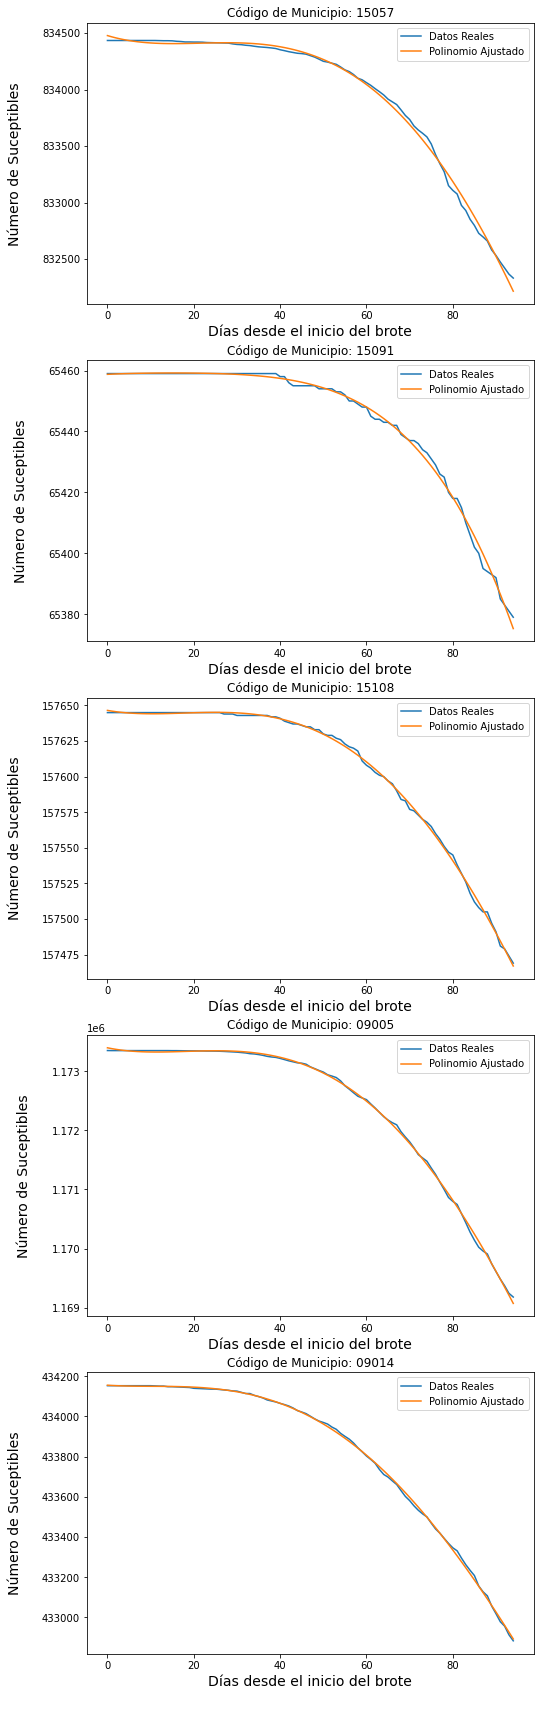

In [291]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))
t = np.array(range(95))

for i in range(5):
    ax[i].plot(range(95), S.iloc[index[i]], label = 'Datos Reales')
    ax[i].plot(t, Σ(t, *paramsSuc[index[i]]), label = 'Polinomio Ajustado')
    ax[i].set_title('Código de Municipio: {}'.format(S.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde el inicio del brote\n', fontsize = 14)
    ax[i].legend()

plt.show()

La ecuación diferencial nos dice que $\frac{dS_i}{dt} = -\lambda_i(t)S_i$, de donde tenemos que $\lambda_i(t) = -\frac{\dot{S_i}}{S_i}$. Además, queremos que la fuerza de infección este en función de los viajes que se realizan desde la ciudad $i$ y los que llegan a la ciudad $i$, del tiempo, de la ciudad en la que se está.

In [300]:
λ = lambda t, i: -dt(Σ, t, n = 1, args = (*paramsSuc[i], )) / Σ(t, *paramsSuc[i])

In [335]:
es = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_entre_semana_por_cve_umun_2020.csv",
                index_col = 0, dtype = {'origen':str})

s = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_sabado_por_cve_umun_2017.csv",
                index_col = 0, dtype = {'origen':str})

d = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_domingo_por_cve_umun_2017.csv",
                index_col = 0, dtype = {'origen':str})

In [336]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [338]:
dfs = []

for t in range(95):
    wd = (fecha_inicio.weekday() + t) % 7
    if wd == 5:  #sábado
        df = s.copy()
    elif wd == 6: #domingo
        df = d.copy()
    else:
        df = es.copy()
            
    if t > inicio_red:
        df = df.multiply(r)
        
    df = pd.concat([df, df.T], axis = 1)
        
    df['t'] = t
    df['i'] = range(47)
    df['f'] = 0.9
    df['Ia'] = range(47)
    df['Im'] = range(47)
    df['Ip'] = range(47)
    df['y'] = range(47)
    
    for i in range(47):
        df.iloc[i, -4] = Ia(t, i)
        df.iloc[i, -3] = Im(t, i)
        df.iloc[i, -2] = Ip(t, i)
        df.iloc[i, -1] = λ(t, i)
        
    dfs.append(df)

In [339]:
main = pd.concat(dfs, axis = 0)

In [344]:
main.head()

,09002,09003,09004,09005,09006,09007,09008,09009,09010,09011,...,15120,15121,15122,t,i,f,Ia,Im,Ip,y
09002,232346.0,12482.0,896.0,47279.0,3891.0,10854.0,1464.0,0.0,5154.0,693.0,...,725.0,5746.0,2383.0,0,0,0.9,0.0,0.0,14.176930,0.000011
09003,9509.0,620410.0,9251.0,23693.0,14445.0,125925.0,71294.0,5832.0,46182.0,33780.0,...,1002.0,1674.0,2385.0,0,1,0.9,0.0,0.0,22.745223,0.000014
09004,1298.0,8531.0,138682.0,2708.0,1243.0,3638.0,3852.0,143.0,34823.0,226.0,...,0.0,739.0,760.0,0,2,0.9,0.0,0.0,21.937170,0.000002
09005,31628.0,25975.0,5323.0,890103.0,9951.0,20588.0,1820.0,277.0,10318.0,3118.0,...,747.0,5618.0,1944.0,0,3,0.9,1.0,0.0,83.484708,0.000013
09006,554.0,14372.0,1174.0,7421.0,319991.0,160054.0,1378.0,621.0,5512.0,4037.0,...,169.0,630.0,1359.0,0,4,0.9,0.0,0.0,18.287753,0.000034


In [340]:
train_X, test_X, train_Y, test_Y = train_test_split(main.iloc[:, :-2], main.iloc[:, -1], test_size = 0.25, random_state = 42)

In [341]:
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [342]:
Y = rf.predict(main.iloc[:, :-2])

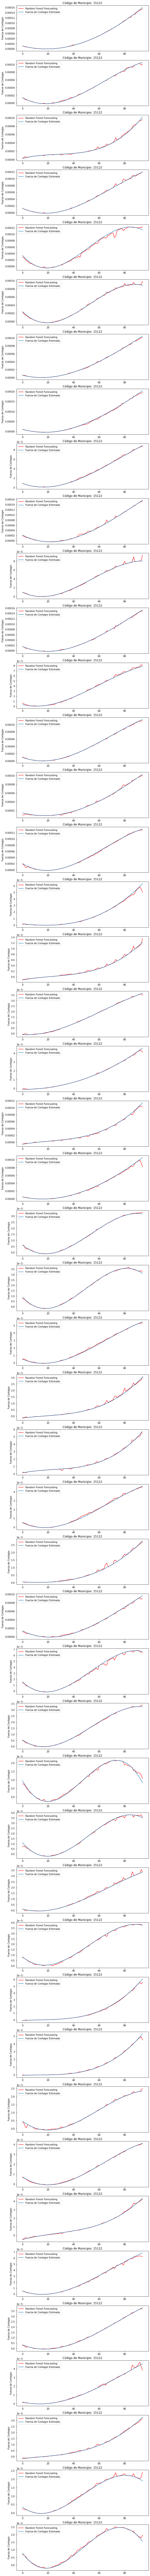

In [343]:
fig, ax = plt.subplots(47, figsize = (10, 200))

t = np.array(range(95))
for k in range(47):
    ax[k].plot(Y[[47*i + k for i in range(95)]], color = 'r', label = 'Random Forest Forecasting')
    ax[k].plot(t, λ(t, k), label = 'Fuerza de Contagio Estimada')
    ax[k].legend()
    ax[k].set_ylabel('Fuerza de Contagio')
    ax[k].set_title('Código de Municipio: {}'.format(acumdefun.index[i]))